# library

In [1]:
import pandas as pd #to read data as dataframe
import numpy as np #for dataframe and list manipulation
import matplotlib.pyplot as plt #for ploting data
import seaborn as sns #just an add on for matplotlib for better color palette
from Bio.Cluster import kcluster #k-mean algorithm
from Bio.Cluster import kmedoids #k-medois algorithm
from sklearn.cluster import AgglomerativeClustering #agnes algorithm to get the clusted id
import scipy.cluster.hierarchy as sch #agnes algorithm to get the dendrogram 
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import DBSCAN #DBSCAN algorithm
import Levenshtein #for levenshtein distance
%matplotlib inline 
#to make jupyter notbook showes matplotlib plots and histogram

# calibrate a list of ADN sequence

In [2]:
def calibrate(list_adn):
    # this fucntion calibrate a list of ADN sequence by filling the empty positiong with "-"
    list_of_adn_len = []
    for adn in list_adn:
        list_of_adn_len.append(len(adn))
    max_len = max(list_of_adn_len)
    for i in range(len(list_adn)):
        list_adn[i] = list_adn[i] + "-" * (max_len-len(list_adn[i]))
    return list_adn

# Reading fasta file as dataframe

In [3]:
def read_fasta(fasta_file):
    # read fasta file
    # this function return a dataframe
    with open(fasta_file, 'r') as f:
        data = []
        ind = ""
        adn = ""
        for line in f:
            if line[0] == ">":
                if len(adn) > 1 and len(ind) > 1:
                    data.append(adn)
                ind = line.strip()
                adn = ""
            else:
                adn = adn + line.strip()
        else:
            data.append(adn)
    data = calibrate(data)
    return pd.DataFrame(data)

# Levenshtein distance

In [4]:
def lev(a,b):
    return Levenshtein.distance(a,b)

# matrix of distnace

In [5]:
def mtx_distnace(df):
    data = df[0].tolist() 
    matrice =[]
    for elem in data:
        min_list = []
        for elem2 in data:         
            min_list.append(lev(elem, elem2))
        matrice.append(min_list)
    return matrice 

# k means

In [6]:
def kmeans_for_genetac_data(df,k=2):
    #we start by converting every character in the DNA seq into his ASCII code
    data = df[0].tolist()
    matrix = np.asarray([np.frombuffer(s.upper().encode(), dtype=np.uint8) for s in data ])
    clusterid, error, nfound = kcluster(matrix,nclusters=k)
    df['clusterid'] = clusterid
    return df    

# k medoids

In [7]:
def k_medoids(df,mtx,k=2):
    clusterid, error, nfound = kmedoids(mtx,nclusters=k)
    df['clusterid'] = clusterid
    return df    

# Agnes

In [8]:
def agnes(df,mtx,k=2):   
    plt.figure(figsize=(16, 6))    
    dists = squareform(mtx)
    linkage_matrix = linkage(dists, 'average')
    dendrogram(linkage_matrix)
#     create clusters
#     single
    hc = AgglomerativeClustering(n_clusters=k, affinity='precomputed',linkage='average')
    # save clusters for chart
    y_hc = hc.fit_predict(mtx)
    df['clusterid'] = y_hc
    return df    

# dbscan

In [9]:
from sklearn.cluster import DBSCAN #DBSCAN algorithm
def dbs(df,mtx,eps=0.5,min_samples=5):
    #eps,default=0.5
    #The maximum distance between two samples for one to be considered as in the neighborhood of the other.

    #min_samplesint, default=5
    #The number of samples in a neighborhood for a point to be considered as a core point.
    #This includes the point itself.
    
    #Noisy samples are given the label -1.
    clustering = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples, algorithm='brute')
    y_db = clustering.fit_predict(mtx)
    return y_db

# Silhouette

In [10]:
def silhouette(df,df2):
    pssible_cluster_id = df['clusterid'].unique().tolist()
    cluster_and_pos = {}
    for cid in pssible_cluster_id:
        cluster_and_pos[cid] = list_of_ind = df.index[df['clusterid'] == cid].tolist()    
    #calculating A(i)
    a = {}
    for i in range(len(df[0].tolist())):
        #calculate som
        som = 0
        cluster_id = df['clusterid'][i]
        for elem in cluster_and_pos[cluster_id]:
            if i != cluster_id:
                som = som + df2[i][elem]
        if len(cluster_and_pos[cluster_id]) > 1:
            a[i]=som/(len(cluster_and_pos[cluster_id])-1)
        else:
            a[i] = 0    
    #calculating B(i)
    b = {}
    #for every element of my dataset
    for i in range(len(df[0].tolist())):
        list_of_som = []
        cluster_id = df['clusterid'][i]
        #for every cluster 
        for c in pssible_cluster_id:
            if c != cluster_id:
                som = 0
                #calclulate the sum of every cluster
                for elem in cluster_and_pos[c]:
                    som = som + df2[i][elem]
                list_of_som.append(som/len(cluster_and_pos[c]))
        try:
            b[i] = min(list_of_som)
        except:
            b[i] = 0
    s = {}
    for i in range(len(df[0].tolist())):
        s[i] = (b[i]-a[i])/(max(b[i],a[i]))   
    pos = 0
    neg = 0
    for val in s.values():
        if val < 0 : neg +=1
        else: pos +=1    
    return ((pos/len(s))*100)

# TESTS

In [11]:
df = read_fasta('dna_examples.fasta')
mtx = mtx_distnace(df)
df2 = pd.DataFrame.from_records(mtx)

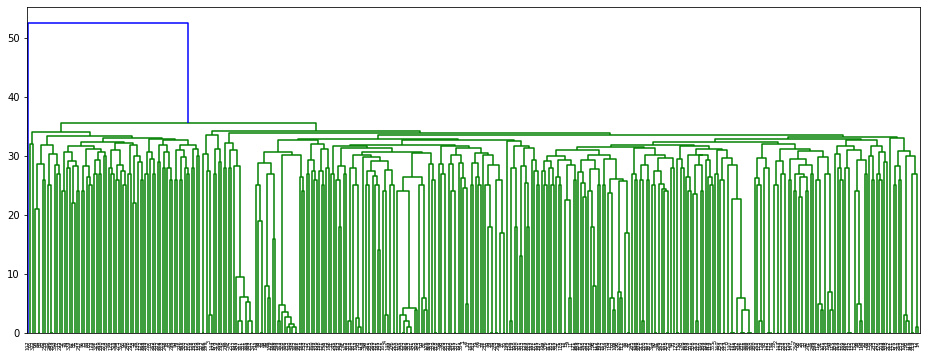

In [12]:
df3 = agnes(df,mtx,k=5)

In [13]:
df['clusterid'].value_counts()

0    285
2     68
1      9
4      2
3      1
Name: clusterid, dtype: int64

In [14]:
kmeans_for_genetac_data(df,k=4)

,0,clusterid
0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,3
1,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,3
2,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,0
3,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,1
4,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,2
...,...,...
360,CTGGTGTGCTCTCTGGTGATCAAGATACAGGTAGGTCATCATCGCA...,1
361,AACCAACTGTTACAATCAAGGTCTATGAAGGTAATTACCTTAAGTT...,1
362,GGCTTCCCGTGCAACCAGTTTGGGCATCAGGTGCGCCGGGCGGAGC...,1
363,GGTGCCTCAGCGTTCGGGCTGGAGACGAGGGTGAGTTTTTCCCCCT...,2


In [15]:
k_medoids(df,mtx,k=4)

,0,clusterid
0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,145
1,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,145
2,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,208
3,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,206
4,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,145
...,...,...
360,CTGGTGTGCTCTCTGGTGATCAAGATACAGGTAGGTCATCATCGCA...,145
361,AACCAACTGTTACAATCAAGGTCTATGAAGGTAATTACCTTAAGTT...,234
362,GGCTTCCCGTGCAACCAGTTTGGGCATCAGGTGCGCCGGGCGGAGC...,206
363,GGTGCCTCAGCGTTCGGGCTGGAGACGAGGGTGAGTTTTTCCCCCT...,145


,0,clusterid
0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,2
1,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,2
2,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,2
3,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,1
4,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,2
...,...,...
360,CTGGTGTGCTCTCTGGTGATCAAGATACAGGTAGGTCATCATCGCA...,2
361,AACCAACTGTTACAATCAAGGTCTATGAAGGTAATTACCTTAAGTT...,0
362,GGCTTCCCGTGCAACCAGTTTGGGCATCAGGTGCGCCGGGCGGAGC...,2
363,GGTGCCTCAGCGTTCGGGCTGGAGACGAGGGTGAGTTTTTCCCCCT...,2


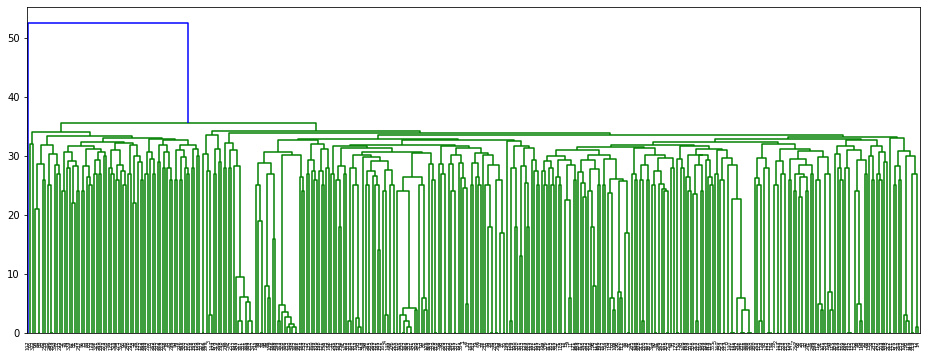

In [16]:
agnes(df,mtx,k=4)

In [17]:
dbs(df,mtx,eps=24,min_samples=2)

array([-1,  0,  1,  2,  0, -1, -1,  1,  0,  3,  0,  3,  4,  3,  4,  3, -1,
       -1, -1, -1, -1, -1,  3, -1, -1,  5,  1,  5,  6,  0,  5,  1,  5,  6,
        0, -1,  1,  5,  6,  0,  5, -1, -1, -1,  1, -1,  7,  3, -1, -1, -1,
        7, -1, -1, -1,  8, -1,  9, 10, -1, -1, 11, -1, -1, 12, -1,  5, -1,
       -1,  1, -1, -1, -1,  9, -1,  8, -1, 13, 10, -1, -1, 11, -1, 11, 12,
       -1, 12,  0, 14, 15,  1, 16,  1, 17, 18, 19,  1,  0, 14, 15,  1, 16,
        1, 17, 18, 19,  1, -1,  0, 14, 15,  1, 16,  1, 17, 18, 19,  1,  3,
       -1, -1, -1, -1, 20, 21, 22, 23, 24, 22, 23, 24,  1, 25, 26,  1, 25,
       26, -1, -1, -1,  1, 25, 26,  1,  2,  0,  1, -1,  1, -1, 27, 28, 15,
       -1, -1, -1, -1, -1, -1, -1, -1, 17,  5, -1, -1,  3, -1, -1,  0, -1,
       29, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, 15,  1,  0,
        1, -1, -1, 30, -1, -1,  6, -1, -1, -1, -1, -1, -1, -1, 21, -1, -1,
       -1, -1,  0, 31, 28, 32, 33, 34, 35, 36, 37,  0, 31, 28, 32, 33, 34,
       35, 36, 37, 38, 38